# Vignette 4: Recovery of dysregulated elements in response to cancer mutations

In this vignette, we will explore another way to evaluate networks, this time using a more biological approach. We will use the Clinical Proteomic Tumor Analysis Consortium (CPTAC) data, a compendium of tissue samples from 10 different cancer types, along with their respective adjacent, healthy tissue, samples.

> Ellis, M. J. et al. Connecting genomic alterations to cancer biology with proteomics: the NCI Clinical Proteomic Tumor Analysis Consortium. *Cancer Discov. 3, 1108–1112 (2013)*.

> Li, Y. et al. Proteogenomic data and resources for pan-cancer analysis. *Cancer Cell 41, 1397–1406 (2023)*.


In this setting, we will use a multiomics approach as follows:
* First, we will identify the most differentially abundant receptors in the proteomics profiles between healthy and tumor samples. We assume that if they are differentially abundant, they will be activated/inhibited.
* Second, we will use the transcriptomics data to perform TF enrichment analysis, in order to get the TFs that are dysregulated in the tumor samples compared to the healthy control.
* Lastly, we will use phosphoproteomics to evaluate the level of dysregulation in the resulting subnetwork, and assess whether these subnetworks contain a higher share of dysregulated elements compared to the overall phosphoproteome.

## 1. Data processing

In [1]:
import networkcommons as nc
import pandas as pd
import numpy as np
import decoupler as dc

NetworkCommons provide a series of util functions to retrieve the CPTAC tables in an easy way. We can use the `cptac_cohorsize()` function to visualise the different cancer samples, and the `cptac_fileinfo()` function to visualise the different files. Finally, we will get the tables using the `cptac_table()` function.

In [2]:
nc.data.omics.datasets()

{'decryptm': 'Drug perturbation proteomics and phosphoproteomics data',
 'panacea': 'Pancancer Analysis of Chemical Entity Activity RNA-Seq data',
 'test': 'Small RNA-Seq data for unit tests',
 'moon': 'Database files for running MOON',
 'cosmos': 'Database files for running COSMOS (MetaPKN)',
 'CPTAC': 'Clinical Proteomic Tumor Analysis Consortium data'}

In [3]:
nc.data.omics.cptac_cohortsize()

,Cancer_type,Tumor,Normal
0,BRCA,122,0
1,CCRCC,103,80
2,COAD,110,100
3,GBM,99,0
4,HNSCC,108,62
5,LSCC,108,99
6,LUAD,110,101
7,OV,83,20
8,PDAC,105,44
9,UCEC,95,18


In [65]:
nc.data.omics.cptac_fileinfo().head()

,File name,Description
0,XXXX_methylation_gene_meta_value_Normal.txt,"Methylation, gene level meta value, normal samples"
1,XXXX_methylation_gene_meta_value_Tumor.txt,"Methylation, gene level meta value, tumor samples"
2,XXXX_miRNAseq_mature_miRNA_RPM_log2_Normal.txt,"miRNAseq, Log2(mature miRNA RPM) of normal samples"
3,XXXX_miRNAseq_mature_miRNA_RPM_log2_Tumor.txt,"miRNAseq, Log2(mature miRNA RPM) of tumor samples"
4,XXXX_phospho_site_abundance_log2_reference_intensity_normalized_Normal.txt,"Phosphoproteomics, Log2(phospho site MS1 intensity), reference intensity normalized, isoform adjusted, normal samples"


In [5]:
nc.data.omics.cptac_datatypes()


['metadata', 'methylation', 'mirna', 'phosphoproteome', 'proteome', 'rna']

In [6]:
cptac_transcriptomics_tumor = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Tumor')
cptac_proteomics_tumor = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor')
cptac_phosphoproteomics_tumor = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Tumor')
cptac_transcriptomics_ctrl = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Normal')
cptac_proteomics_ctrl = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Normal')
cptac_phosphoproteomics_ctrl = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Normal')
cptac_meta = nc.data.omics.cptac_table('metadata', 'LSCC', 'meta')

In [7]:
transcriptomics = pd.merge(cptac_transcriptomics_ctrl, cptac_transcriptomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
proteomics = pd.merge(cptac_proteomics_ctrl, cptac_proteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
phosphoproteomics = pd.merge(cptac_phosphoproteomics_ctrl, cptac_phosphoproteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))

Now, since we have duplicated the samples by adding either _ctrl or _tumor suffixes, we need to update the according metadata

In [8]:
transcriptomics_meta = pd.DataFrame({'sample': transcriptomics.set_index('idx').columns.to_list()})
transcriptomics_meta['group'] = transcriptomics_meta['sample'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [9]:
proteomics_meta = pd.DataFrame({'sample': proteomics.set_index('idx').columns.to_list()})
proteomics_meta['group'] = proteomics_meta['sample'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [10]:
phosphoproteomics_meta = pd.DataFrame({'sample': phosphoproteomics.set_index('idx').columns.to_list()})
phosphoproteomics_meta['group'] = phosphoproteomics_meta['sample'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [11]:
transcriptomics.head()

,idx,C3L-00081_ctrl,C3L-00415_ctrl,C3L-00445_ctrl,C3L-00568_ctrl,C3L-00603_ctrl,C3L-00904_ctrl,C3L-00923_ctrl,C3L-00927_ctrl,C3L-00993_ctrl,...,C3N-03851_tumor,C3N-03875_tumor,C3N-03877_tumor,C3N-03880_tumor,C3N-03882_tumor,C3N-03886,C3N-04124_tumor,C3N-04127_tumor,C3N-04155,C3N-04162_tumor
0,ENSG00000000003.15,9.1619,9.3218,8.8822,8.8718,9.6118,10.4317,9.9718,8.6323,9.3118,...,10.0918,10.5617,10.7817,9.6418,11.4716,10.4017,9.7217,10.4517,9.9219,11.0117
1,ENSG00000000005.6,1.4765,1.9343,1.7468,0.9565,0.9042,1.8829,1.8178,1.7328,0.0000,...,1.4384,1.3214,1.0009,1.5088,2.7509,1.1369,1.0160,1.9121,0.7763,1.4765
2,ENSG00000000419.12,9.4618,9.5618,9.4020,9.1718,9.3219,9.2818,9.3819,9.2020,9.3118,...,10.3017,9.9618,10.1117,9.7218,10.7817,9.7016,9.9217,10.9117,9.7019,9.2119
3,ENSG00000000457.14,9.7718,9.8017,9.2320,9.6418,9.8818,9.8818,9.8018,9.5219,9.3618,...,9.7618,10.0418,10.1617,10.2317,9.7218,11.4818,9.9317,9.6118,9.1322,9.8518
4,ENSG00000000460.17,7.8223,8.3819,8.0227,7.8720,8.0723,8.0322,8.1723,7.5332,7.7722,...,9.8118,9.0621,10.6017,9.7518,9.5219,11.6618,9.3917,8.7419,9.1921,9.6418


In [12]:
phosphoproteomics.head()

,idx,C3L-02665_ctrl,C3L-01663_ctrl,C3N-02575_ctrl,C3L-02546_ctrl,C3L-02963_ctrl,C3N-04162_ctrl,C3L-02646_ctrl,C3N-02285_ctrl,C3N-03875_ctrl,...,C3N-03425_tumor,C3L-02163_tumor,C3N-04124_tumor,C3L-00904_tumor,C3N-00211,C3N-01892_tumor,C3L-00603_tumor,C3L-03965_tumor,C3N-03851_tumor,C3L-02349_tumor
0,ENSG00000000419.12|ENSP00000360644.5|S21|RRELEVRSPRQNKYS|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000000457.14|ENSP00000356746.4|S533|SEEWPDWSEPEEPEN|1,20.15139,20.518985,20.12092,19.524927,NaN,20.197389,20.428171,NaN,19.430541,...,19.894803,20.270334,20.555754,20.636069,20.059452,19.963673,19.312416,19.589386,20.048120,20.029813
2,ENSG00000000457.14|ENSP00000356746.4|S558|EPCDDVKSQCTTLDV|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.781297,14.657933,14.248313,14.958611,15.152006
3,ENSG00000000457.14|ENSP00000356746.4|S569|TLDVEESSWDDCEPS|1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.551497,19.657661,20.039314,20.200392,20.044415,19.576859,18.991163,18.908664,19.818676,19.886261
4,ENSG00000000457.14|ENSP00000356746.4|S577|WDDCEPSSLDTKVNP|1,NaN,NaN,NaN,NaN,17.802051,18.106032,16.735936,17.474137,18.096801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since NAs in proteomics and phosphoproteomics are quite ubiquitous, we use a filling strategy using the mean for those elements which have less than 10% of the values missing. Otherwise, we remove the row.

In [13]:
transcriptomics = nc.utils.handle_missing_values(transcriptomics)

Number of genes filled: 0
Number of genes removed: 0


In [14]:
proteomics = nc.utils.handle_missing_values(proteomics)

Number of genes filled: 802
Number of genes removed: 3318


In [15]:
phosphoproteomics = nc.utils.handle_missing_values(phosphoproteomics)

Number of genes filled: 4746
Number of genes removed: 56800


As a quality control metric, we can plot PCAs to see if there are differences between tumor and control samples.

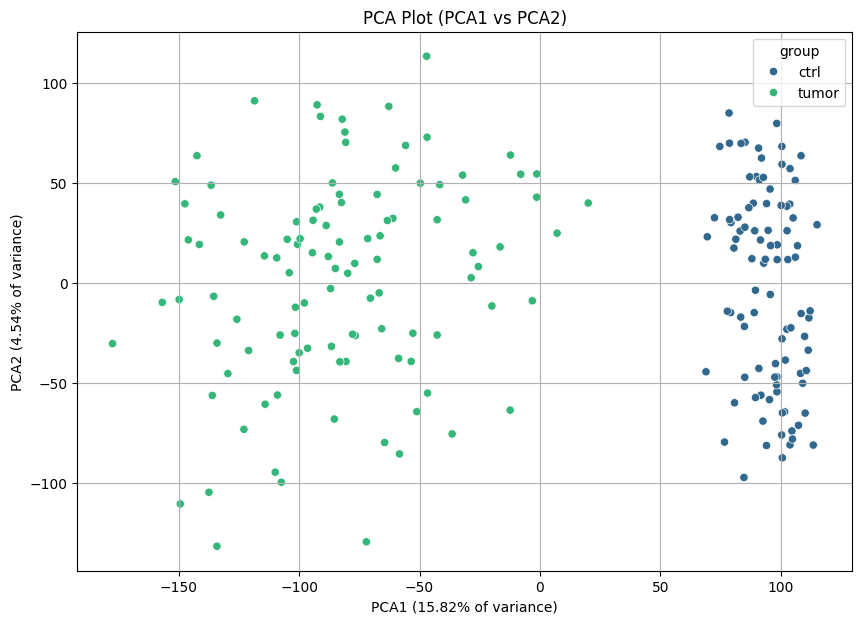

,PCA1,PCA2,group
0,106.909830,18.647262,ctrl
1,79.127035,-14.830255,ctrl
2,83.073833,26.008220,ctrl
3,80.513726,17.490366,ctrl
4,115.026522,29.164289,ctrl
...,...,...,...
197,-91.142362,83.414181,tumor
198,-83.077097,-39.457716,tumor
199,-58.328614,-85.558163,tumor
200,-134.083283,-30.067460,tumor


In [16]:
nc.visual.plot_pca(transcriptomics, transcriptomics_meta)

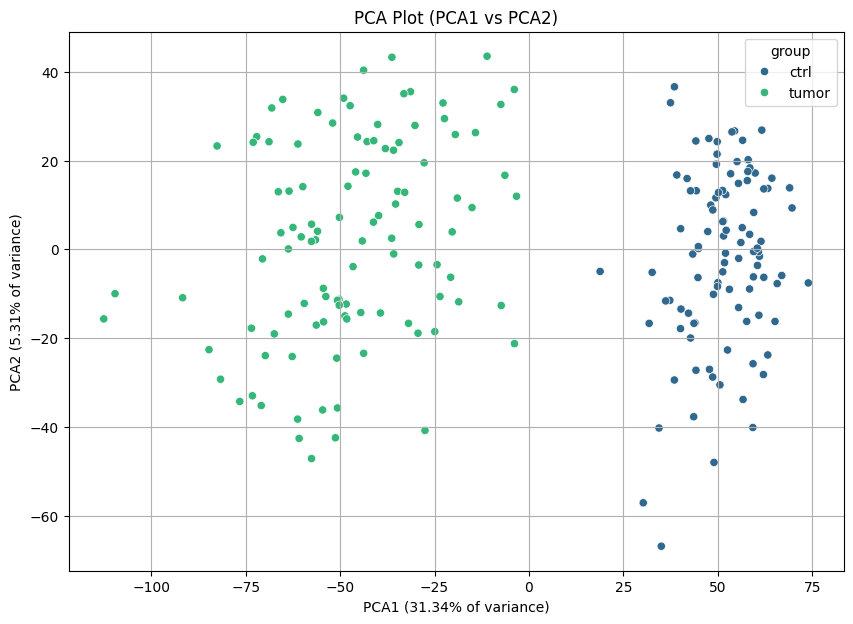

,PCA1,PCA2,group
0,43.622306,-37.733160,ctrl
1,44.305112,13.214138,ctrl
2,49.847993,24.287721,ctrl
3,59.430243,-6.199677,ctrl
4,48.995198,-48.026952,ctrl
...,...,...,...
202,-41.086690,24.496501,tumor
203,-51.976524,28.476946,tumor
204,-48.222467,-15.683624,tumor
205,-73.009733,24.134081,tumor


In [17]:
nc.visual.plot_pca(phosphoproteomics, phosphoproteomics_meta)

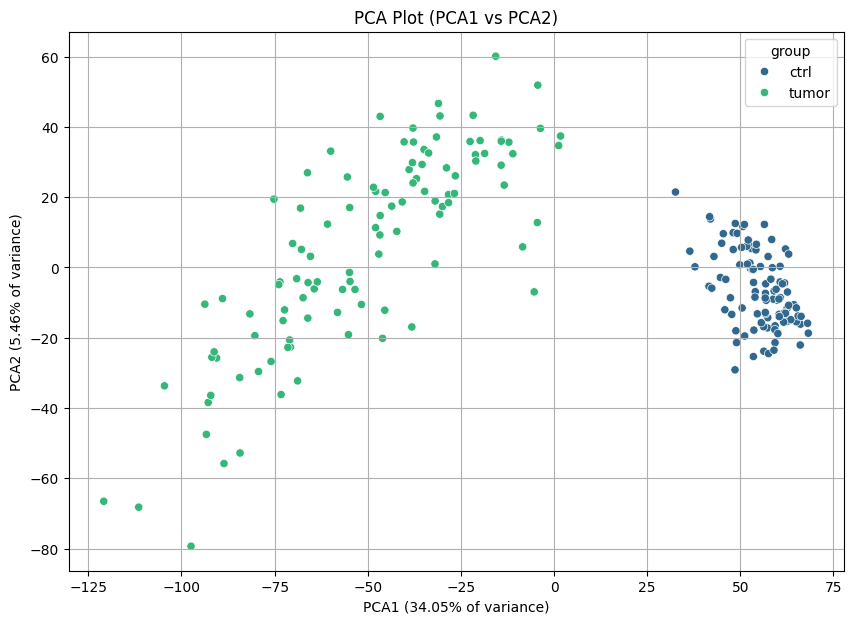

,PCA1,PCA2,group
0,56.460184,12.249527,ctrl
1,50.674229,11.655029,ctrl
2,58.424016,7.944418,ctrl
3,62.538869,-11.643741,ctrl
4,59.310804,-21.416607,ctrl
...,...,...,...
202,-48.453630,22.810047,tumor
203,-75.946722,-26.755692,tumor
204,-46.023526,-20.177188,tumor
205,-91.228312,-24.027237,tumor


In [18]:
nc.visual.plot_pca(proteomics, proteomics_meta)

And there are! We can easily differentiate the healthy and tumor tissues.

Now, since the data is indexed using ENSEMBL IDs, but our prior-knowledge network is in gene symbols, we will use the `get_ensembl_mappings()` and `convert_ensembl_to_gene_symbol()` to convert them.

In [19]:
ensembl_mapping = nc.data.omics.get_ensembl_mappings()

In [20]:
transcriptomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(transcriptomics, ensembl_mapping)

Number of non-matched Ensembl IDs: 19731 (32.52%)
['gene_symbol']
Number of summarized duplicated entries: 19787 (32.61%)


In [21]:
proteomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(proteomics, ensembl_mapping)

Number of non-matched Ensembl IDs: 4 (0.04%)
['gene_symbol']
Number of summarized duplicated entries: 4 (0.04%)


For phosphoproteomics, since we want to keep the phosphosite-level information, we need to translate the ensembl ids and then concatenate them to the phosphosite-specific fifteenmer.

In [22]:
phosphoproteomics[['gene', 'prot', 'psite', 'seq', 'n']] = phosphoproteomics['idx'].str.split('|', expand=True)
phosphoproteomics.drop('idx', inplace=True, axis=1)

In [23]:
phospho_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(phosphoproteomics, ensembl_mapping, column_name='gene')

Number of non-matched Ensembl IDs: 6 (0.07%)
['prot' 'psite' 'seq' 'n' 'gene_symbol']
Number of summarized duplicated entries: 6 (0.07%)


In [24]:
phospho_renamed['gene_symbol_seq'] = phospho_renamed['gene_symbol'] + '_' + phospho_renamed['seq']
phospho_renamed.drop(columns=['seq', 'prot', 'psite', 'n', 'gene_symbol'], inplace=True)
phospho_renamed.head()

,C3L-02665_ctrl,C3L-01663_ctrl,C3N-02575_ctrl,C3L-02546_ctrl,C3L-02963_ctrl,C3N-04162_ctrl,C3L-02646_ctrl,C3N-02285_ctrl,C3N-03875_ctrl,C3N-03424_ctrl,...,C3L-02163_tumor,C3N-04124_tumor,C3L-00904_tumor,C3N-00211,C3N-01892_tumor,C3L-00603_tumor,C3L-03965_tumor,C3N-03851_tumor,C3L-02349_tumor,gene_symbol_seq
0,24.778932,24.144195,24.245553,24.187865,23.991156,24.624274,23.925634,24.189010,24.203136,25.194671,...,24.449057,23.827787,24.628376,24.798447,24.181133,24.707735,24.829209,24.645253,24.593752,M6PR_DDQLGEESEERDDHL
1,22.878684,22.674447,23.582689,23.335581,23.589888,23.896592,23.503831,24.009229,23.622921,23.854899,...,25.110112,23.899580,24.694385,24.514119,24.422219,24.587323,24.398015,25.285522,25.235690,USP28_PPTIRPNSPYDLCSR
2,28.580501,29.273960,28.864482,29.449294,29.829316,28.151902,29.272367,30.600724,29.556550,29.312504,...,26.640254,27.256747,27.131390,27.178108,27.758667,27.433369,28.225481,27.645598,27.535508,HSPB6_PSWLRRASAPLPGLS
3,22.811642,22.491214,22.275141,22.671035,22.955886,21.295732,21.021387,21.957105,21.157406,22.574189,...,23.401272,23.247106,24.953356,24.600228,23.091636,23.522764,23.402343,23.461673,24.553480,BAIAP2L1_PSLQRSVSVATGLNM
4,21.059257,20.350320,19.616710,20.346401,20.488712,18.926078,18.542495,19.062845,19.883743,22.258148,...,20.432237,20.724834,20.925029,20.604330,21.043552,20.856591,21.133605,20.283046,20.622167,OSBPL7_ESLHRIPSAPVIPTH


Now, we can perform differential expression analysis with DESeq2.

In [25]:
de_transcr = nc.data.omics.deseq2(transcriptomics_renamed, transcriptomics_meta, ref_group='ctrl', test_group='tumor', feature_col='gene_symbol', sample_col='sample', round_values=True)

Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 11.85 seconds.

Fitting dispersion trend curve...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 41.60 seconds.

Fitting LFCs...
... done in 8.20 seconds.

Calculating cook's distance...
... done in 0.96 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.37 seconds.



Log2 fold change & Wald test p-value: group tumor vs ctrl
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_symbol                                                                
A1BG          4.742500        0.033628  0.094226  0.356882  7.211802e-01   
A1BG-AS1      7.340147       -0.079629  0.075575 -1.053649  2.920436e-01   
A1CF          3.119675        0.290504  0.117753  2.467060  1.362275e-02   
A2M          15.831610       -0.274551  0.051456 -5.335677  9.518893e-08   
A2M-AS1       7.674712       -0.285300  0.073876 -3.861859  1.125277e-04   
...                ...             ...       ...       ...           ...   
ZYG11B       11.223439       -0.064672  0.061131 -1.057921  2.900913e-01   
ZYX          11.118272       -0.108338  0.061389 -1.764769  7.760252e-02   
ZYXP1         0.000000             NaN       NaN       NaN           NaN   
ZZEF1        11.785252       -0.044394  0.059673 -0.743957  4.569025e-01   
ZZZ3         10.996321        

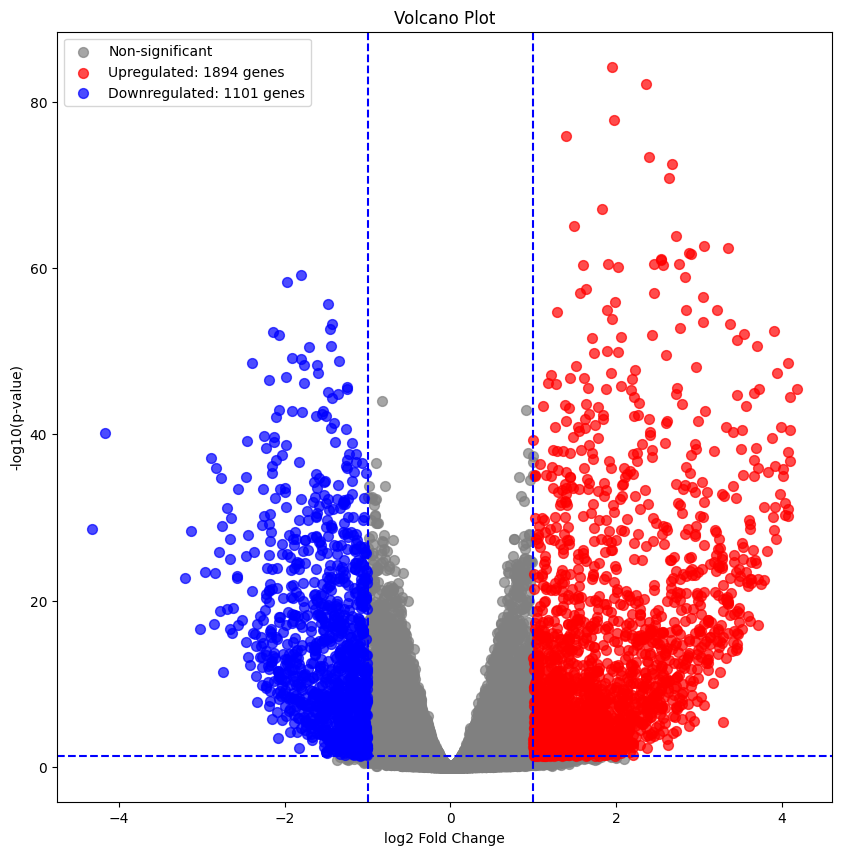

In [26]:
nc.visual.build_volcano_plot(data=de_transcr, log2fc='log2FoldChange', pval='padj')

In [27]:
de_prot = nc.data.omics.deseq2(proteomics_renamed, proteomics_meta, ref_group='ctrl', test_group='tumor', feature_col='gene_symbol', sample_col='sample', round_values=True)

Fitting size factors...
... done in 0.08 seconds.

Fitting dispersions...
... done in 6.13 seconds.

Fitting dispersion trend curve...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.27 seconds.

/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Fitting MAP dispersions...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-

Log2 fold change & Wald test p-value: group tumor vs ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_symbol                                                                   
A1BG         28.680311       -0.056978  0.037471 -1.520619  0.128355  0.999779
A2M          30.319057       -0.081396  0.036438 -2.233837  0.025494  0.899615
A2ML1        24.020306        0.075093  0.041032  1.830124  0.067231  0.999779
AAAS         24.126653        0.012712  0.040889  0.310897  0.755879  0.999779
AACS         24.677737        0.051569  0.040460  1.274565  0.202463  0.999779
...                ...             ...       ...       ...       ...       ...
ZXDC         21.516271        0.051633  0.043331  1.191601  0.233418  0.999779
ZYG11B       22.695789       -0.035193  0.042131 -0.835325  0.403535  0.999779
ZYX          28.806004       -0.034987  0.037397 -0.935574  0.349492  0.999779
ZZEF1        25.020953       -0.000616  0.040143 -0.015336  0.987764  0.9

... done in 0.84 seconds.



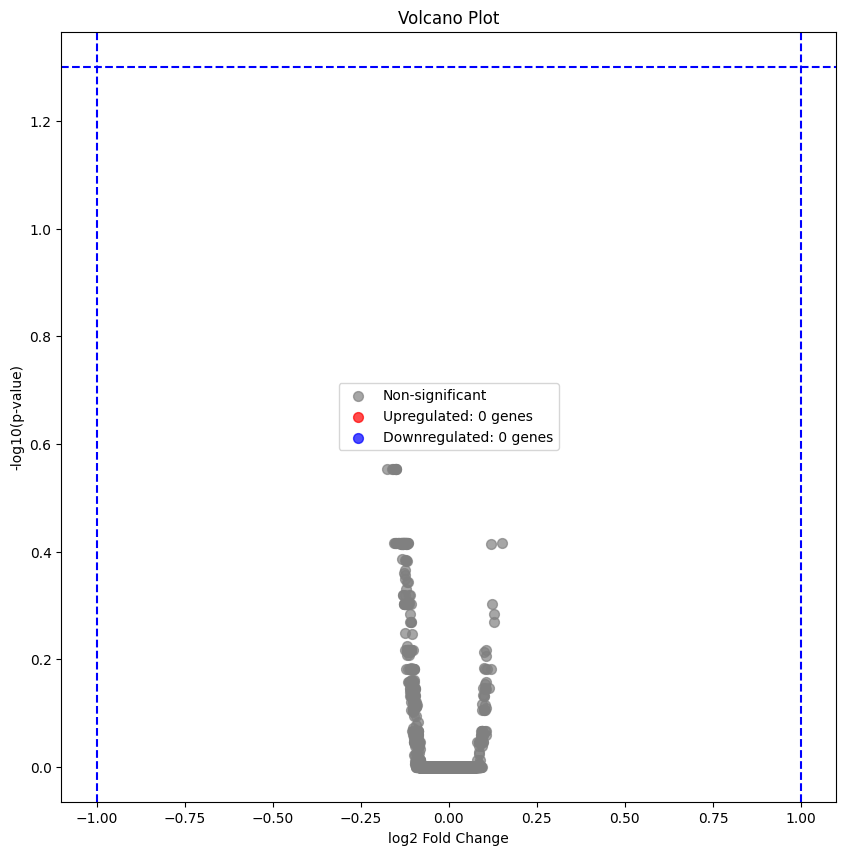

In [28]:
nc.visual.build_volcano_plot(data=de_prot, log2fc='log2FoldChange', pval='padj')

In [29]:
phospho_renamed.drop_duplicates(subset=['gene_symbol_seq'], inplace=True)

In [30]:
de_phospho = nc.data.omics.deseq2(phospho_renamed, phosphoproteomics_meta, ref_group='ctrl', test_group='tumor', feature_col='gene_symbol_seq', sample_col='sample', round_values=True)

Fitting size factors...
... done in 0.08 seconds.

Fitting dispersions...
... done in 4.06 seconds.

Fitting dispersion trend curve...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.26 seconds.

/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Fitting MAP dispersions...
/home/victo/.cache/pypoetry/virtualenvs/networkcommons-DX9y6Uxu-py3.10/lib/python3.10/site-

Log2 fold change & Wald test p-value: group tumor vs ctrl
                           baseMean  log2FoldChange     lfcSE      stat  \
gene_symbol_seq                                                           
M6PR_DDQLGEESEERDDHL      24.458733       -0.010454  0.040580 -0.257627   
USP28_PPTIRPNSPYDLCSR     24.120598        0.049106  0.040906  1.200471   
HSPB6_PSWLRRASAPLPGLS     28.574285       -0.091635  0.037517 -2.442535   
BAIAP2L1_PSLQRSVSVATGLNM  22.947025        0.095357  0.041985  2.271197   
OSBPL7_ESLHRIPSAPVIPTH    20.444956        0.015826  0.044403  0.356410   
...                             ...             ...       ...       ...   
LDB1_KRRKRKMSGGSTMSS      21.507524        0.036058  0.043308  0.832601   
SYNJ1_AQLSVQTSPVPTPDP     20.904192       -0.032051  0.043883 -0.730376   
SYNJ1_SQENMRSSPNPFITG     22.348235       -0.046288  0.042435 -1.090809   
SYNJ1_RASAGRLTPESQSKT     24.275348       -0.038316  0.040719 -0.940974   
LIN52_FEKLDRASPDLWPEQ     21.807218       

... done in 0.76 seconds.



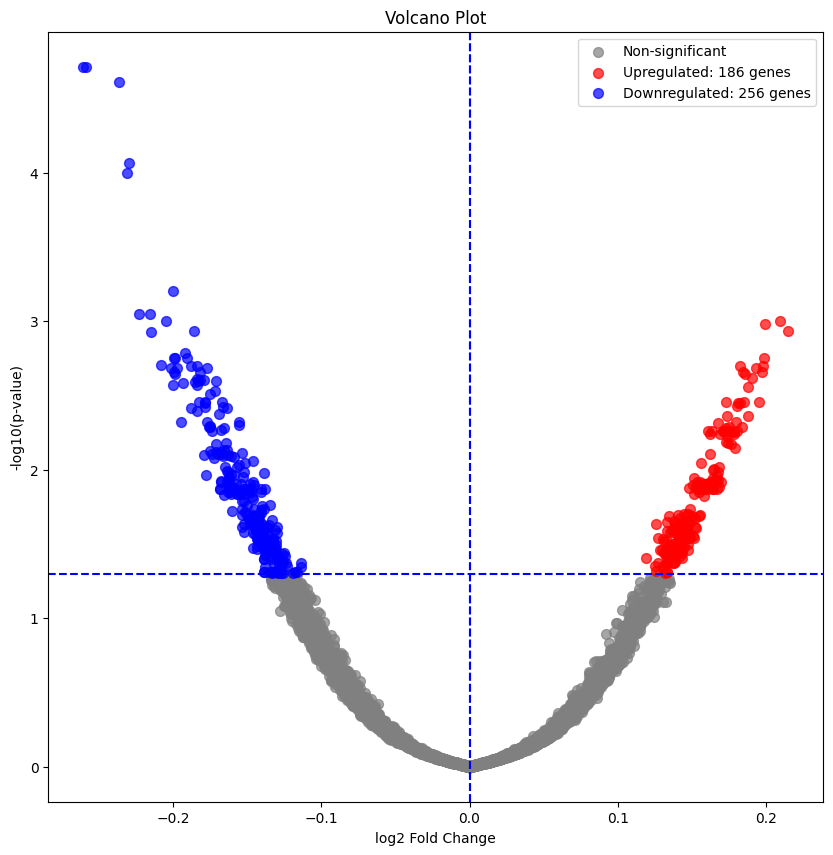

In [31]:
nc.visual.build_volcano_plot(data=de_phospho, log2fc='log2FoldChange', pval='padj', log2fc_threshold=0)

## 2. Prior knowledge and inputs

Now that we have our data preprocessed, we can proceed to defining the inputs of the network inference methods. For the upstream layer, we will identify the most abundant receptors (using information from LIANA) in the proteome. For the downstream layer, we will perform TF activity estimation using the transcriptomics data.

In [32]:
liana_receptors = nc.data.network.get_lianaplus()

In [33]:
receptors = set(liana_receptors.target)

In [34]:
receptors_prot = de_prot[de_prot.index.isin(receptors)]

top_receptors = receptors_prot.sort_values(by='stat', key=lambda x: x.abs(), ascending=False).head(5)

In [35]:
top_receptors

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
CCBE1,21.066737,-0.174563,0.043714,-3.993273,0.000065,0.279942
ACKR3,18.925230,0.151665,0.046328,3.273738,0.001061,0.384288
CAV1,29.096061,-0.121249,0.037191,-3.260141,0.001114,0.384288
AGER,28.719002,-0.120221,0.037435,-3.211485,0.001321,0.384288
CD36,25.557545,-0.127201,0.039683,-3.205461,0.001348,0.384288


In [36]:
source_dict = top_receptors['stat'].to_dict()

We can see the overall abundance of these receptors in the original data.

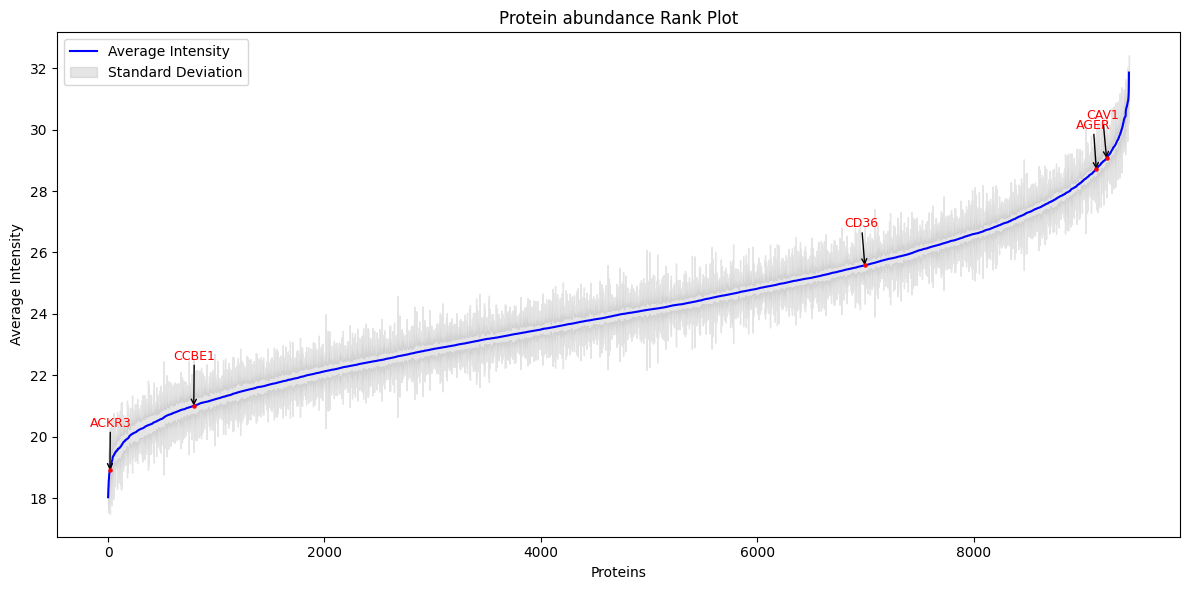

In [37]:
nc.visual.plot_rank(proteomics_renamed, bio_ids=source_dict.keys(), id_column='gene_symbol')

They seem to gather in the extremes of the rank, which is expected since these are the ones that have the highest t-values.

Now, we can perform TF activity estimation and use them as downstream measurements

In [38]:
collectri = dc.get_collectri()

In [39]:
de_transcr.dropna(inplace=True)
decoupler_input = nc.utils.decoupler_formatter(de_transcr, 'stat')
dc_estimates, dc_pvals = dc.run_ulm(decoupler_input, collectri)
measurements = nc.utils.targetlayer_formatter(dc_estimates.T)

Now that we have our inputs, we can get the network from OmniPath.

In [40]:
network = nc.data.network.get_omnipath()
graph = nc.utils.network_from_df(network)

Lastly, we will perform Kinase activity estimation using PhosphoSitePlus. We will then use this information to evaluate the network on the basis of wether its nodes are overall more dysregulated than the overall phosphoproteome landscape.

In [53]:
phosphositeplus = nc.data.network.get_phosphositeplus()
phosphositeplus = phosphositeplus[phosphositeplus['KIN_ORGANISM'] == 'human']
phosphositeplus['target'] = phosphositeplus['SUB_GENE'] + '_' + phosphositeplus['SITE_+/-7_AA'].str.upper()
phosphositeplus.rename(columns={'KINASE': 'source'}, inplace=True)
phosphositeplus.drop_duplicates(subset=['source', 'target'], inplace=True)
phosphositeplus = phosphositeplus[['source', 'target']]
phosphositeplus.head()

,source,target
5,HRI,Eif2s1_MILLSELSRRRIRSI
6,HRI,EIF2S1_RILLSELSR______
7,HRI,EIF2S1_MILLSELSRRRIRSI
8,HRI,EIF2S1_IEGMILLSELSRRRI
9,PKCD,Sdc4_MKKKDEGSYDLGKKP


In [57]:
kinases = set(phosphositeplus.source)
len(kinases)

445

In [58]:
decoupler_input_kin = nc.utils.decoupler_formatter(de_phospho, 'stat')
dc_estimates_kin, dc_pvals_kin = dc.run_zscore(decoupler_input_kin, phosphositeplus, weight=None)
kinase_activities = dc_estimates_kin.T
kinase_activities.head()
len(kinase_activities)

55

We could infer activities for 55 out of the 445 available kinases.

In [59]:
kinase_activities.head()

,stat
AMPKA1,2.868164
ATM,0.879243
Abl,-2.797513
Akt1,-1.360799
Akt2,0.338361


## 3. Network inference

Now, we can perform network inference using basic topological methods. We will store the network in a dictionary to ease further downstream analysis.

In [44]:
networks = {}

In [45]:
networks['shortest_path'], shortest_paths_list = nc.methods.run_shortest_paths(graph, source_dict, measurements)

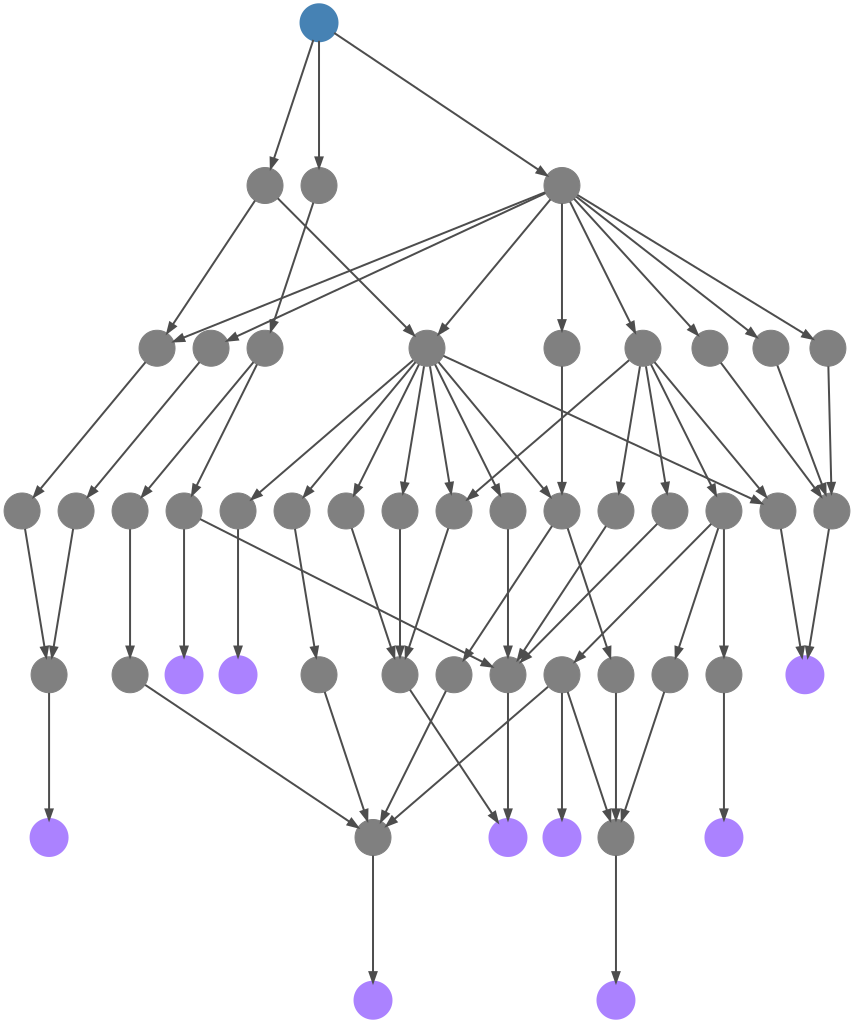

In [46]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['shortest_path'], source_dict, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

In [47]:
networks['shortest_sc_path'], shortest_sc_list = nc.methods.run_sign_consistency(networks['shortest_path'], shortest_paths_list, source_dict, measurements)

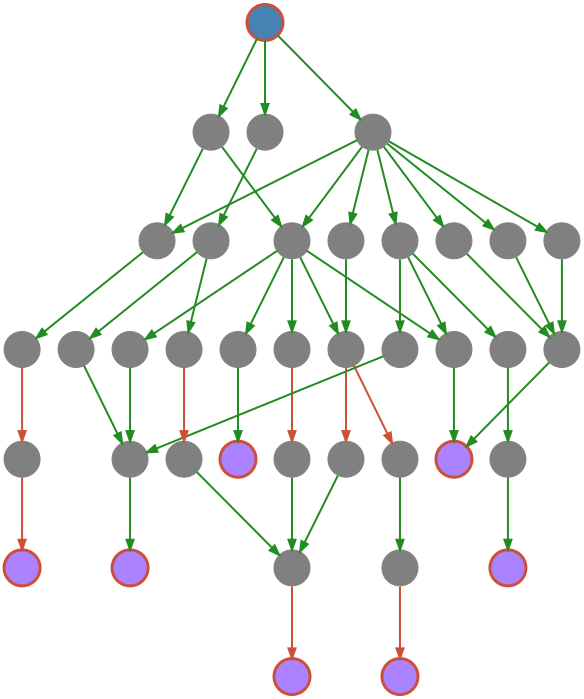

In [48]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['shortest_sc_path'], source_dict, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

In [49]:
networks['all_paths'], all_paths_list = nc.methods.run_all_paths(graph, source_dict, measurements, depth_cutoff=6)

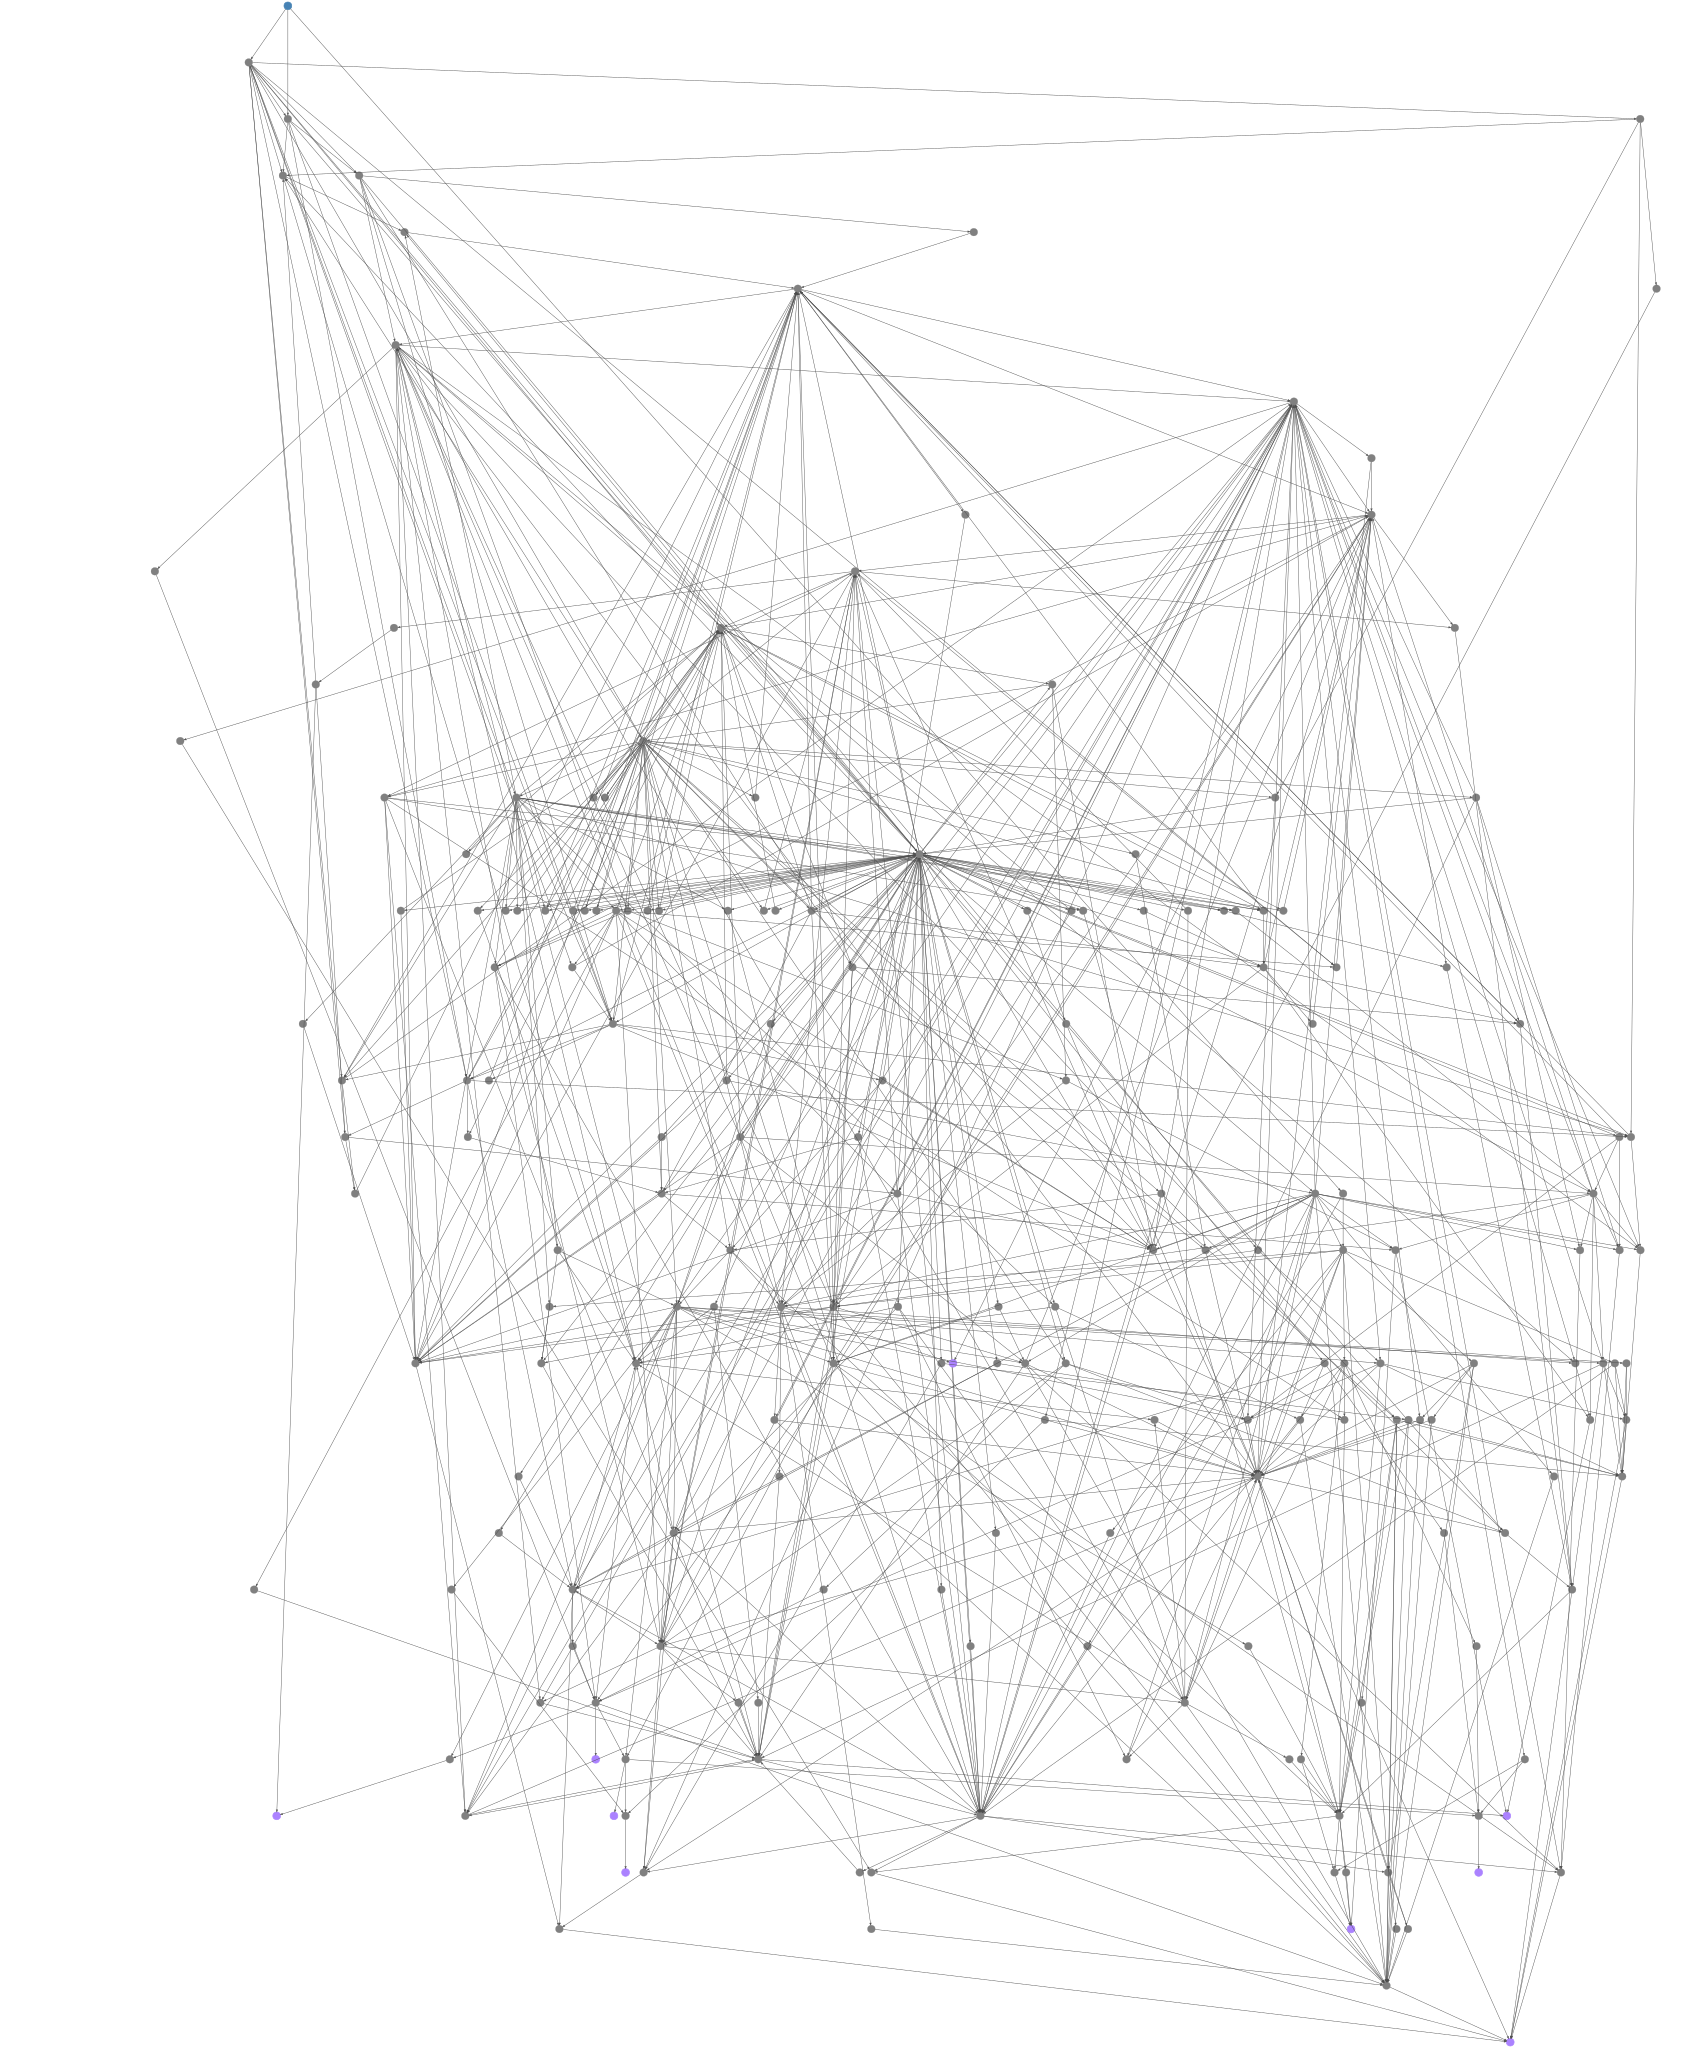

In [50]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['all_paths'], source_dict, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

In [51]:
networks['all_sc_paths'], allpaths_sc_list = nc.methods.run_sign_consistency(networks['all_paths'], all_paths_list, source_dict, measurements)

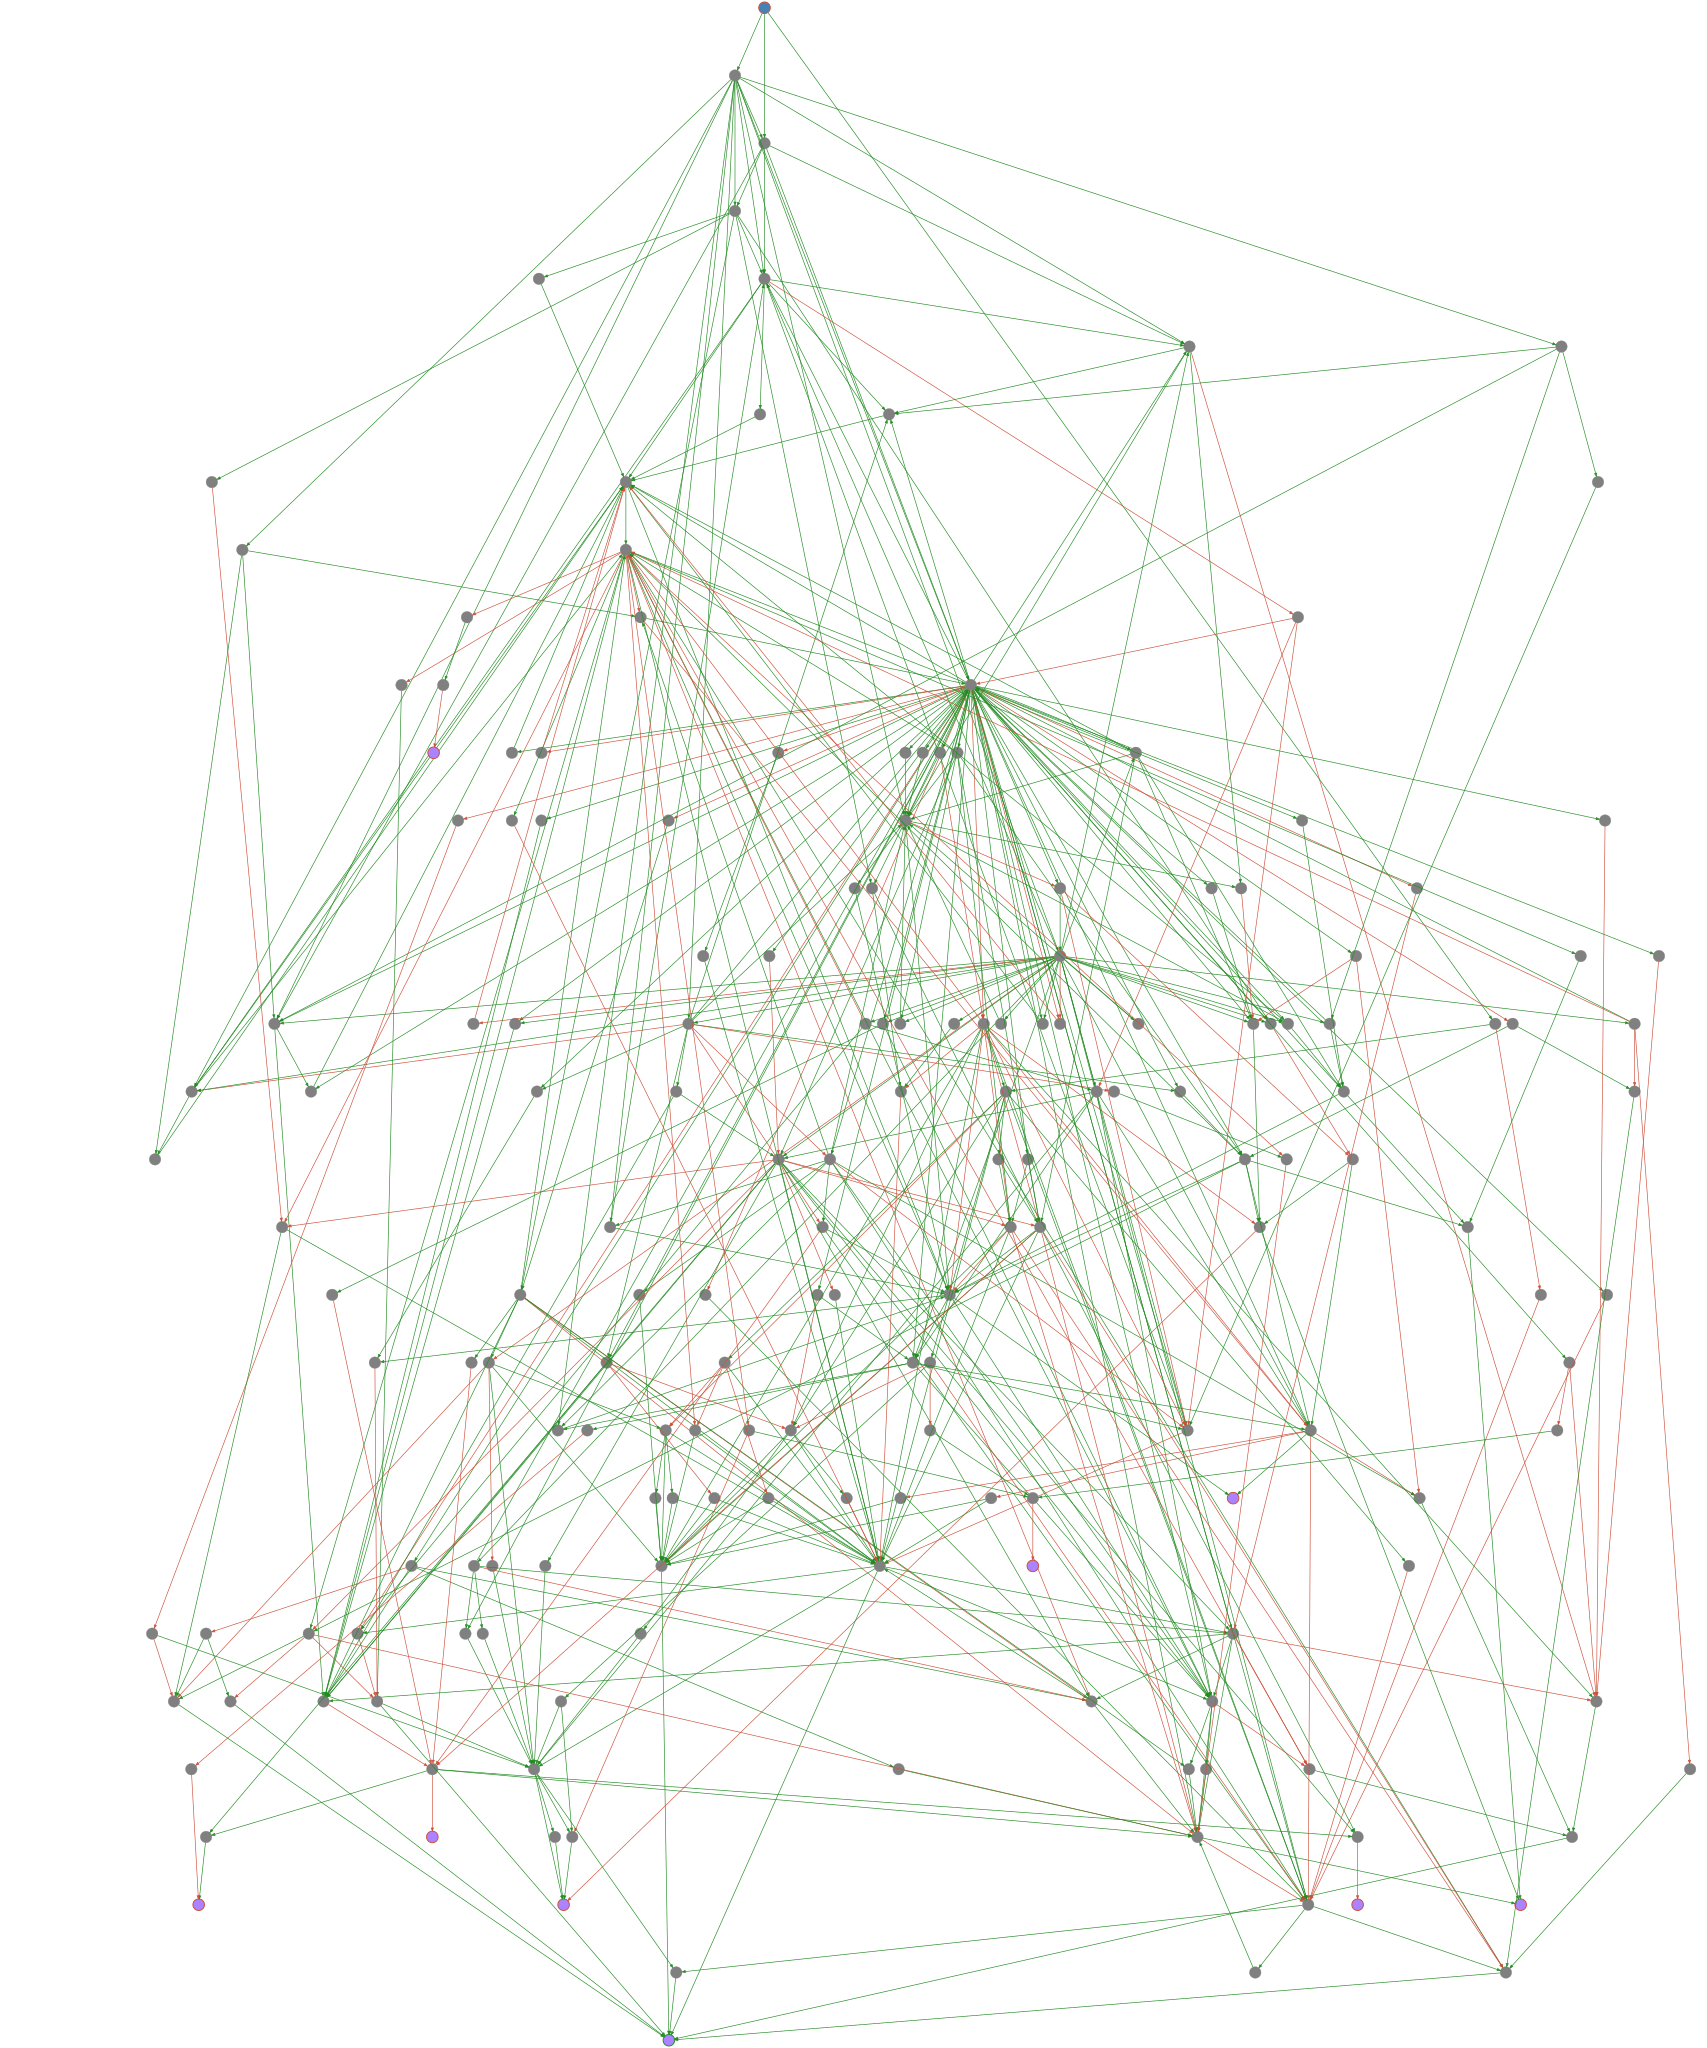

In [52]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['all_sc_paths'], source_dict, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

## 3. Network evaluation using level of dysregulation in the phosphoproteome.

Now, at last, we are in the position to test our hypotheses. In this section, we will use the kinase activities to evaluate whether the inferred networks capture a more extreme dysregulation status (understood as average kinase activity score for the nodes in the network, versus the overall kinase activity) than the random controls (node label shuffling, but keeping the topology of the network intact).

In [61]:
sp_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_shortest_paths, 10, 'shortest_path', source_dict=source_dict, target_dict=measurements)

In [63]:
ap_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_all_paths, 10, 'all_paths', source_dict=source_dict, target_dict=measurements, depth_cutoff=6)

In [64]:
combined_dict = {}
combined_dict.update(networks)
combined_dict.update(sp_random_controls)
combined_dict.update(ap_random_controls)

In [ ]:
phospho_results = nc.eval.get_metric_from_networks(combined_dict, nc.eval.get_phosphorylation_status, dataframe=kinase_activities)

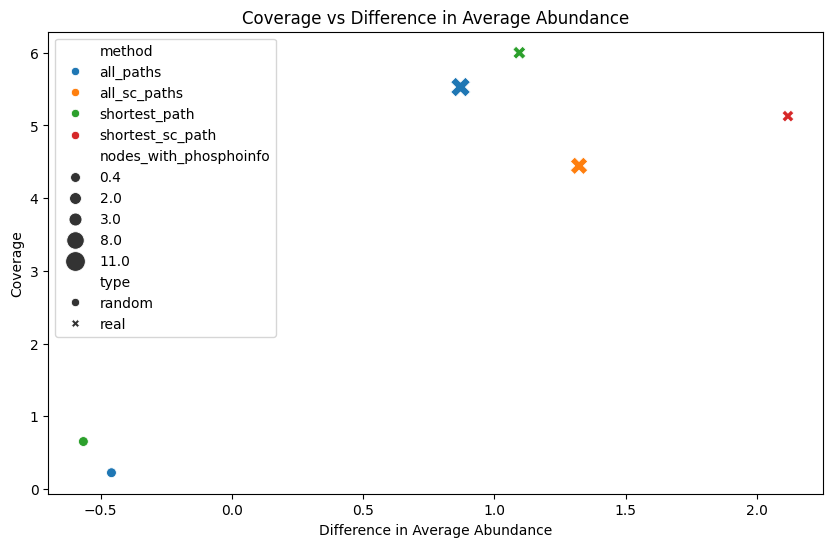

In [60]:
nc.visual.plot_scatter(phospho_results)

The results show that our contextualised networks manage to recover a higher share of dysregulation, which means that in this scenario, the network methods perform much than a random model, especially the sign consistent methods. However, the coverage is very low, which means that these results should not be fully trusted.

<div class="alert alert-block alert-info">
<b>⚠️</b> This approach has the flaw of having usually low coverage of kinase activities, thus the inferred dysregulation does not have too solid grounds. This evaluation setting is still under development.
</div>